# Predicting interest rates from Federal Reserve documents
## Exploratory Data Analysis/ Feature Engineering (Vol. 4)
FE 690: Machine Learning in Finance \\
Author: Theo Dimitrasopoulos \\
Advisor: Zachary Feinstein \\

## Environment

In [46]:
import sys
import os
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [47]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [48]:
#if IN_COLAB:
#  # Uninstall existing versions:
#  !pip uninstall bs4 -y
#  !pip uninstall textract -y
#  !pip uninstall numpy -y
#  !pip uninstall pandas -y
#  !pip uninstall requests -y
#  !pip uninstall tqdm -y
#  !pip uninstall nltk -y
#  !pip uninstall quandl -y
#  !pip uninstall scikit-plot -y
#  !pip uninstall seaborn -y
#  !pip uninstall sklearn -y
#  !pip uninstall torch -y
#  !pip uninstall transformers -y
#  !pip uninstall wordcloud -y
#  !pip uninstall xgboost -y
#  
#  # Install packages:
#  !pip install bs4==0.0.1
#  !pip install textract==1.6.3
#  !pip install numpy==1.19.4
#  !pip install pandas==1.1.4
#  !pip install requests==2.24.0
#  !pip install tqdm==4.51.0
#  !pip install nltk==3.5
#  !pip install quandl==3.5.3
#  !pip install scikit-plot==0.3.7
#  !pip install seaborn==0.11.0
#  !pip install sklearn==0.0
#  !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#  !pip install transformers==3.5.0
#  !pip install wordcloud==1.8.0
#  !pip install xgboost==1.2.1
#  os.kill(os.getpid(), 9)
#

In [49]:
if IN_COLAB:
  employment_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/models/'
  graph_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/graphs/'
else:
  employment_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/models/'
  graph_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/graphs/'


In [50]:
# Python libraries
import pprint
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import time
import logging
import random
from collections import defaultdict, Counter
import xgboost as xgb

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns; sns.set(style='white', context='notebook', palette='deep')

# Import Scikit-learn models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW
plt.style.use('ggplot')
sns.set()

In [51]:
# Fiinalize nltk setup:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Test pprint
pprint.pprint(sys.path)


['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [52]:
## Use TPU Runtime:
#if IN_COLAB:
#  assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'  
#  VERSION = "20200220"
#  !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#  !python pytorch-xla-env-setup.py --version $VERSION

In [53]:
## Use GPU Runtime:
if IN_COLAB:
  if torch.cuda.is_available():
    torch.cuda.get_device_name(0)
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    print(gpu_info)
  else:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, and then re-execute this cell.')
    os.kill(os.getpid(), 9)  


Mon Jan 25 11:52:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [54]:
# Load nontext data
if IN_COLAB:
  file = open('/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/nontext_data.pickle', 'rb')
  nontext_data = pickle.load(file)
  file.close()
else:
  file = open('C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/nontext_data.pickle', 'rb')
 
print(nontext_data.shape)
nontext_data.head()

(390, 57)


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision,RateChanged,GDP_date,GDP_value,GDP_diff_prev,GDP_diff_year,GDPPOT_date,GDPPOT_value,GDPPOT_diff_prev,GDPPOT_diff_year,PCE_date,PCE_value,PCE_diff_prev,PCE_diff_year,CPI_date,CPI_value,CPI_diff_prev,CPI_diff_year,Unemp_date,Unemp_value,Unemp_diff_prev,Unemp_diff_year,Employ_date,Employ_value,Employ_diff_prev,Employ_diff_year,PMI_date,PMI_value,PMI_diff_prev,PMI_diff_year,NMI_date,NMI_value,NMI_diff_prev,NMI_diff_year,Rsales_date,Rsales_value,Rsales_diff_prev,Rsales_diff_year,Hsales_date,Hsales_value,Hsales_diff_prev,Hsales_diff_year,Taylor,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-0.5,-1,1,1982-04-01,6825.876,0.456197,-1.010549,1982-04-01,7224.140335,0.781241,2.925225,1982-08-01,47.798,0.460287,6.369058,1982-08-01,97.7,0.205128,5.965293,1982-09-01,-10.1,-0.3,-2.5,1982-09-01,89183.0,-180.0,-2294.0,1982-09-01,38.8,0.5,-3.7,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,1982-09-01,481.0,18.181818,42.307692,7.718209,4.882832,7.767575,-2.281791,-5.117168,-2.232425,NaN,NaN,NaN
1982-11-16,False,False,False,Paul Volcker,9.0,-0.5,-1,1,1982-07-01,6799.781,-0.382295,-2.555898,1982-07-01,7282.431567,0.806895,3.080461,1982-09-01,47.975,0.370308,6.068981,1982-10-01,98.1,0.409417,5.032120,1982-10-01,-10.4,-0.3,-2.5,1982-10-01,88907.0,-276.0,-2473.0,1982-10-01,39.4,0.6,-0.6,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,1982-10-01,480.0,-0.207900,34.831461,6.674751,3.246030,7.588095,-2.825249,-6.253970,-1.911905,-1.043459,-1.636801,-0.179480
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0,0,1982-07-01,6799.781,-0.382295,-2.555898,1982-07-01,7282.431567,0.806895,3.080461,1982-10-01,48.279,0.633663,6.110024,1982-11-01,98.0,-0.101937,4.477612,1982-11-01,-10.8,-0.4,-2.5,1982-11-01,88786.0,-121.0,-2385.0,1982-11-01,39.2,-0.2,3.1,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,1982-11-01,554.0,15.416667,45.026178,6.736316,3.307596,6.728861,-1.763684,-5.192404,-1.771139,0.061565,0.061565,-0.859235
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0,0,1982-07-01,6799.781,-0.382295,-2.555898,1982-07-01,7282.431567,0.806895,3.080461,1982-11-01,48.458,0.370762,5.884409,1982-12-01,97.7,-0.306122,3.825717,1982-12-01,-10.8,0.0,-2.3,1982-12-01,88771.0,-15.0,-2124.0,1982-12-01,42.8,3.6,5.0,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,1982-12-01,521.0,-5.956679,14.004376,6.397894,2.969174,6.779624,-2.102106,-5.530826,-1.720376,-0.338422,-0.338422,0.050763
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0,0,1982-07-01,6799.781,-0.382295,-2.555898,1982-07-01,7282.431567,0.806895,3.080461,1982-11-01,48.458,0.370762,5.884409,1982-12-01,97.7,-0.306122,3.825717,1982-12-01,-10.8,0.0,-2.3,1982-12-01,88771.0,-15.0,-2124.0,1982-12-01,42.8,3.6,5.0,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,1982-12-01,521.0,-5.956679,14.004376,6.397894,2.969174,6.779624,-2.102106,-5.530826,-1.720376,0.000000,0.000000,0.000000


In [55]:
if IN_COLAB:
  file = open('/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/nontext_ma2.pickle', 'rb')
  nontext_ma2 = pickle.load(file)
  file.close()
  file = open('/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/nontext_ma3.pickle', 'rb')
  nontext_ma3 = pickle.load(file)
  file.close()
  file = open('/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/nontext_ma6.pickle', 'rb')
  nontext_ma6 = pickle.load(file)
  file.close()
  file = open('/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/nontext_ma12.pickle', 'rb')
  nontext_ma12 = pickle.load(file)
  file.close()
else:
  file = open('C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/nontext_ma2.pickle', 'rb')
  nontext_ma2 = pickle.load(file)
  file.close()
  file = open('C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/nontext_ma3.pickle', 'rb')
  nontext_ma3 = pickle.load(file)
  file.close()
  file = open('C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/nontext_ma6.pickle', 'rb')
  nontext_ma6 = pickle.load(file)
  file.close()
  file = open('C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/nontext_ma12.pickle', 'rb')
  nontext_ma12 = pickle.load(file)
  file.close()

## Non-text dataset analysis

In [56]:
nontext_data['prev_decision'] = nontext_data['RateDecision'].shift(1)
nontext_data['next_decision'] = nontext_data['RateDecision'].shift(-1)
nontext_data[['RateDecision', 'prev_decision', 'next_decision']].head()

,RateDecision,prev_decision,next_decision
date,,,
1982-10-05,-1,<NA>,-1
1982-11-16,-1,-1,0
1982-12-21,0,-1,0
1983-01-14,0,0,0
1983-01-21,0,0,0


In [57]:
nontext_data.describe()

,Rate,RateDiff,RateDecision,RateChanged,GDP_value,GDP_diff_prev,GDP_diff_year,GDPPOT_value,GDPPOT_diff_prev,GDPPOT_diff_year,PCE_value,PCE_diff_prev,PCE_diff_year,CPI_value,CPI_diff_prev,CPI_diff_year,Unemp_value,Unemp_diff_prev,Unemp_diff_year,Employ_value,Employ_diff_prev,Employ_diff_year,PMI_value,PMI_diff_prev,PMI_diff_year,NMI_value,NMI_diff_prev,NMI_diff_year,Rsales_value,Rsales_diff_prev,Rsales_diff_year,Hsales_value,Hsales_diff_prev,Hsales_diff_year,Taylor,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff,prev_decision,next_decision
count,390.000000,390.000000,390.000000,390.000000,390.00000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,109.000000,109.000000,95.000000,274.000000,273.000000,261.000000,390.000000,390.000000,390.000000,390.000000,3.900000e+02,390.000000,390.000000,390.000000,3.900000e+02,389.000000,389.000000,389.000000,389.000000,389.000000
mean,4.141346,-0.025641,-0.020513,0.348718,12450.45391,0.647576,2.594788,12647.034520,0.657539,2.675490,79.810964,0.202530,2.545792,171.807374,0.210972,2.912594,-6.165385,-0.004872,0.031026,122219.761538,116.135897,1450.212821,51.907692,0.112564,0.207692,53.567890,0.079817,0.444211,162192.989051,0.099778,1.759999,678.897436,0.217508,1.870612,3.985859,3.285348e+00,3.049682,-0.181769,-0.882280,-1.117946e+00,-0.009525,-0.001417,-0.021638,-0.020566,-0.017995
std,3.056928,0.239839,0.590925,0.477177,3542.17116,0.623227,1.954636,3563.685301,0.204059,0.829742,17.791826,0.128590,1.169539,47.419321,0.266780,1.312575,1.684240,0.173877,1.015984,16670.894430,229.611742,2016.072738,5.575810,1.927176,7.850502,4.625571,2.036599,4.490906,23139.191426,1.051423,3.353409,221.563467,7.158610,20.041156,1.726425,1.931121e+00,2.382148,1.724834,2.000109,7.057038e-01,0.305632,0.395506,0.204568,0.591685,0.589588
min,0.000000,-1.000000,-1.000000,0.000000,6799.78100,-2.163811,-3.924447,7224.140335,0.263026,1.080299,47.798000,-0.559925,0.911787,97.700000,-1.770548,-1.958761,-10.800000,-0.900000,-4.000000,88771.000000,-1373.000000,-6823.000000,33.100000,-5.900000,-19.300000,37.600000,-7.100000,-9.400000,118156.000000,-7.916341,-11.403148,270.000000,-33.649289,-46.411483,-0.724407,1.021405e-14,-0.649747,-4.782348,-7.591582,-2.639534e+00,-1.833373,-2.444734,-1.073487,-1.000000,-1.000000
25%,1.250000,0.000000,0.000000,0.000000,9341.64200,0.396135,1.722931,9578.876710,0.484126,1.970276,66.176000,0.124268,1.656575,134.200000,0.102539,2.036888,-7.175000,-0.100000,-0.375000,108395.750000,18.000000,462.000000,49.000000,-0.975000,-5.200000,51.700000,-1.100000,-2.400000,143427.000000,-0.367248,1.094438,534.250000,-4.616762,-10.236869,3.081423,2.187279e+00,0.804419,-1.499382,-2.001425,-1.581143e+00,-0.153118,-0.131186,-0.046978,0.000000,0.000000
50%,4.375000,0.000000,0.000000,0.000000,12345.14650,0.631956,2.694679,12142.911975,0.648491,2.672563,79.012000,0.185014,2.113604,165.300000,0.216920,2.828638,-5.800000,0.000000,0.300000,128358.500000,173.000000,2104.500000,52.400000,0.100000,0.150000,54.500000,0.200000,-0.300000,162934.500000,0.164436,2.214409,650.000000,-0.217329,2.821760,3.938901,3.428082e+00,3.243321,-0.378437,-0.662186,-1.191838e+00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.187500,0.000000,0.000000,1.000000,15645.57475,0.970216,3.908121,15938.819440,0.822396,3.316956,94.579500,0.259326,3.415452,214.406500,0.347826,3.779077,-4.900000,0.100000,0.600000,134513.000000,251.000000,2713.000000,55.800000,1.100000,4.650000,56.600000,1.400000,2.950000,177878.750000,0.682932,3.706026,778.000000,4.977692,13.362917,4.855993,4.477121e+00,4.618443,1.216621,0.040471,-5.579491e-01,0.118919,0.104743,0.034124,0.000000,0.000000
max,11.500000,1.125000,1.000000,1.000000,19221.97000,2.275605,8.578274,19099.880000,1.064642,4.300945,112.886000,0.716645,6.369058,259.050000,1.376849,6.379585,-3.50000

In [58]:
nontext_data.isnull().sum()

unscheduled           0
forecast              0
confcall              0
ChairPerson           0
Rate                  0
RateDiff              0
RateDecision          0
RateChanged           0
GDP_date              0
GDP_value             0
GDP_diff_prev         0
GDP_diff_year         0
GDPPOT_date           0
GDPPOT_value          0
GDPPOT_diff_prev      0
GDPPOT_diff_year      0
PCE_date              0
PCE_value             0
PCE_diff_prev         0
PCE_diff_year         0
CPI_date              0
CPI_value             0
CPI_diff_prev         0
CPI_diff_year         0
Unemp_date            0
Unemp_value           0
Unemp_diff_prev       0
Unemp_diff_year       0
Employ_date           0
Employ_value          0
Employ_diff_prev      0
Employ_diff_year      0
PMI_date              0
PMI_value             0
PMI_diff_prev         0
PMI_diff_year         0
NMI_date            281
NMI_value           281
NMI_diff_prev       281
NMI_diff_year       295
Rsales_date         116
Rsales_value    

Count: 
 0    254
-1     72
 1     64
Name: RateDecision, dtype: Int64
Percent: 
 0    65.0
-1    18.0
 1    16.0
Name: RateDecision, dtype: float64


Text(0.5, 1.0, 'nontext_data')

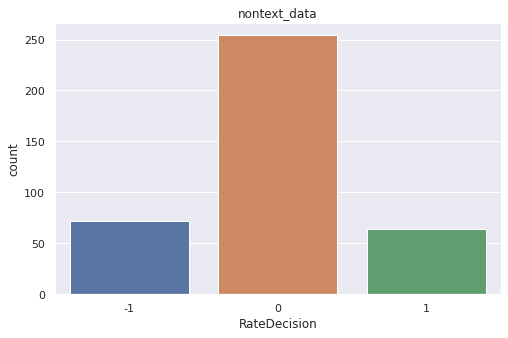

In [59]:
x = nontext_data['RateDecision'].value_counts()
print("Count: ")
print(x)
print("Percent: ")
print(round(x/sum(x) * 100))
plt.figure(figsize=(8,5))
ax = sns.countplot(x='RateDecision', data=nontext_data)
ax.set_title('nontext_data')

## Correlation

In [60]:
nontext_data.columns.values

array(['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate',
       'RateDiff', 'RateDecision', 'RateChanged', 'GDP_date', 'GDP_value',
       'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_date', 'GDPPOT_value',
       'GDPPOT_diff_prev', 'GDPPOT_diff_year', 'PCE_date', 'PCE_value',
       'PCE_diff_prev', 'PCE_diff_year', 'CPI_date', 'CPI_value',
       'CPI_diff_prev', 'CPI_diff_year', 'Unemp_date', 'Unemp_value',
       'Unemp_diff_prev', 'Unemp_diff_year', 'Employ_date',
       'Employ_value', 'Employ_diff_prev', 'Employ_diff_year', 'PMI_date',
       'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 'NMI_date',
       'NMI_value', 'NMI_diff_prev', 'NMI_diff_year', 'Rsales_date',
       'Rsales_value', 'Rsales_diff_prev', 'Rsales_diff_year',
       'Hsales_date', 'Hsales_value', 'Hsales_diff_prev',
       'Hsales_diff_year', 'Taylor', 'Balanced', 'Inertia', 'Taylor-Rate',
       'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff',
       'Inertia_diff', 'prev_decision'

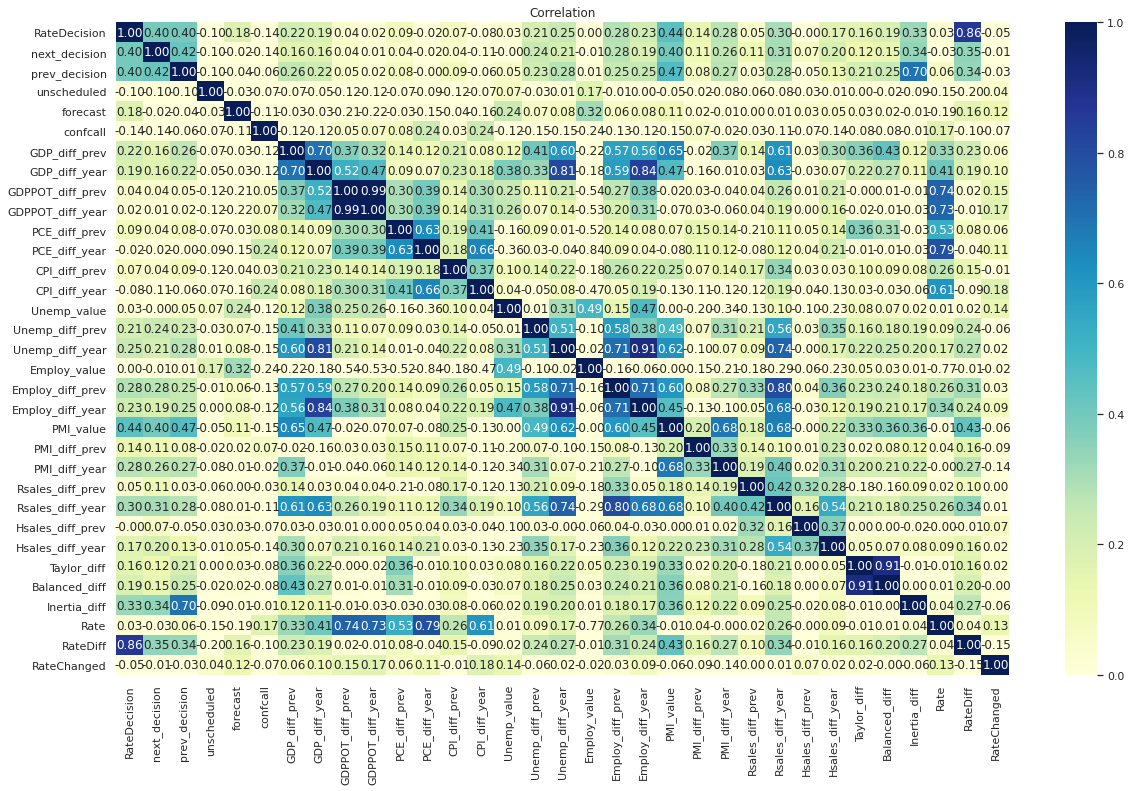

In [61]:
corr_columns = ['RateDecision', 'next_decision', 'prev_decision', 'unscheduled', 'forecast', 'confcall', 
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Rate', 'RateDiff', 'RateChanged']
 
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
 
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax)
ax.set_title("Correlation")
plt.show()

### Moving average

In [62]:
corr_columns = ['RateDecision',
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate']

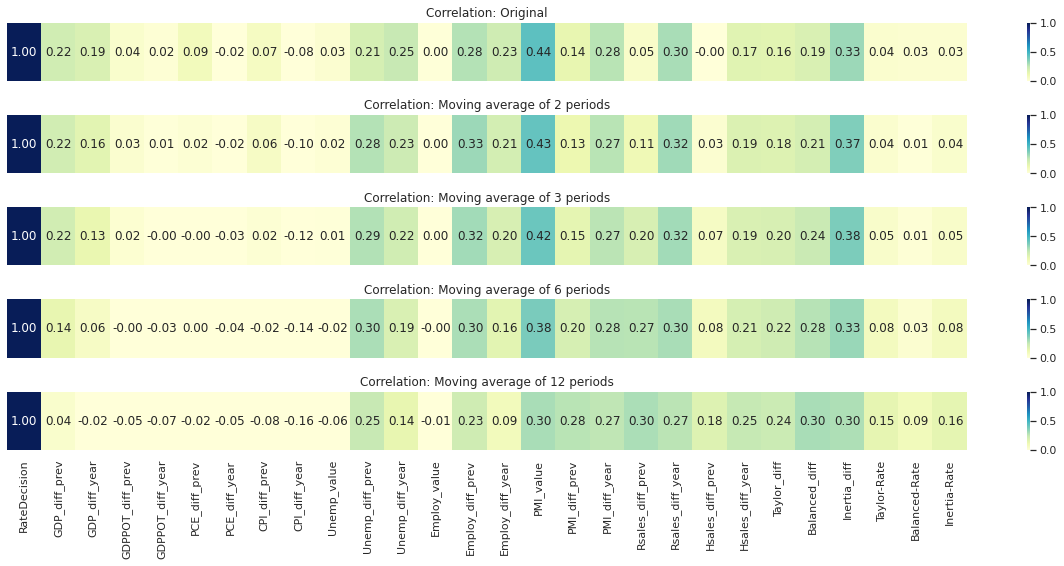

In [63]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(17,8))
 
sns.heatmap(nontext_data[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Correlation: Original")
ax1.set_xticks([])
ax1.set_yticks([])
sns.heatmap(nontext_ma2[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Correlation: Moving average of 2 periods")
ax2.set_xticks([])
ax2.set_yticks([])
sns.heatmap(nontext_ma3[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax3)
ax3.set_title("Correlation: Moving average of 3 periods")
ax3.set_xticks([])
ax3.set_yticks([])
sns.heatmap(nontext_ma6[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax4)
ax4.set_title("Correlation: Moving average of 6 periods")
ax4.set_xticks([])
ax4.set_yticks([])
sns.heatmap(nontext_ma12[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax5)
ax5.set_title("Correlation: Moving average of 12 periods")
ax5.set_yticks([])
 
fig.tight_layout(pad=1.0)
plt.show()

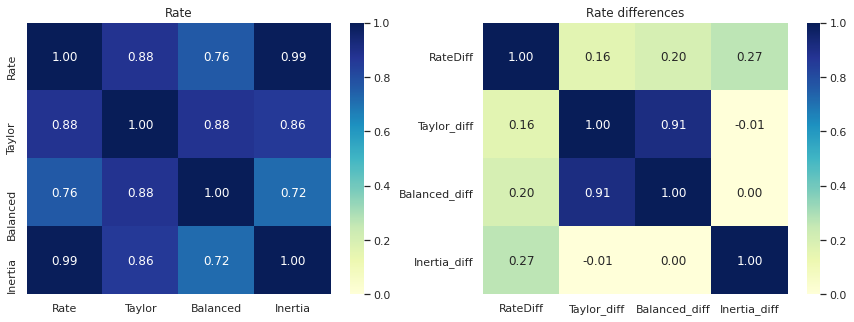

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
 
corr_columns = ['Rate', 'Taylor', 'Balanced', 'Inertia']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Rate")
 
corr_columns = ['RateDiff', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Rate differences")
 
plt.show()

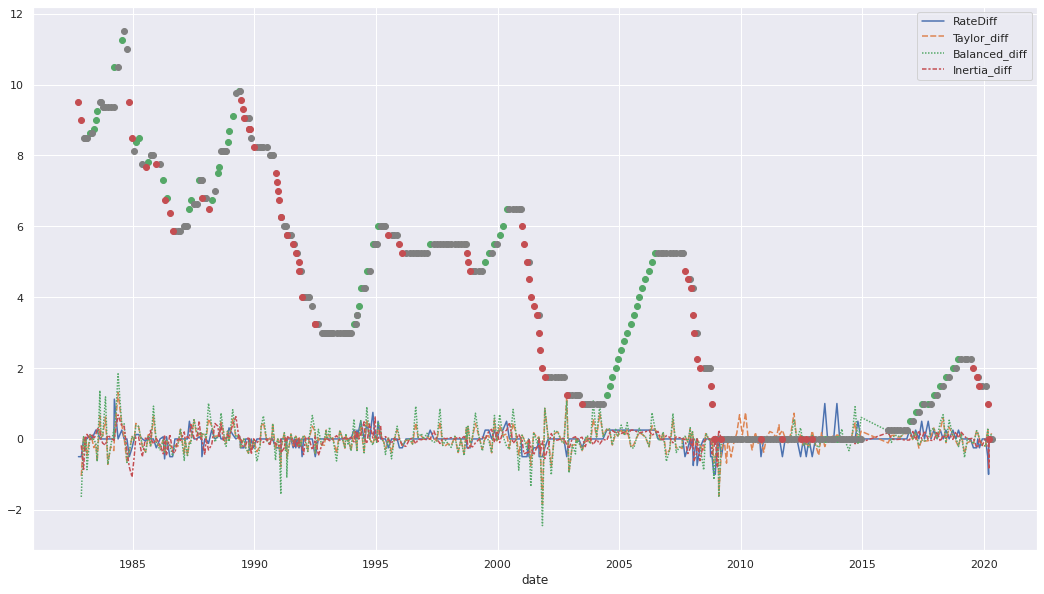

In [65]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.lineplot(data=nontext_data[corr_columns], ax=ax)
 
decision_raise = nontext_data.loc[nontext_data['RateDecision'] == 1]
decision_hold = nontext_data.loc[nontext_data['RateDecision'] == 0]
decision_lower = nontext_data.loc[nontext_data['RateDecision'] == -1]
 
ax.plot(decision_raise.index.values, decision_raise['Rate'], 'o', color="g", label="Raise")
ax.plot(decision_hold.index.values, decision_hold['Rate'], 'o', color="grey", label="Hold")
ax.plot(decision_lower.index.values, decision_lower['Rate'], 'o', color="r", label="Lower")

### Check individual columns

In [66]:
def plot_distribution(df, columns):
    for col in columns:        
        fig, ax = plt.subplots(figsize=(10, 5))
        g = sns.kdeplot(df[col][(df["RateDecision"] == -1) & (df[col].notnull())], color="Red", shade=True)
        g = sns.kdeplot(df[col][(df["RateDecision"] == 0) & (df[col].notnull())], ax=g, color="Blue", shade=True)
        g = sns.kdeplot(df[col][(df["RateDecision"] == 1) & (df[col].notnull())], ax=g, color="Green", shade=True)
        g.set_xlabel(col)
        g.set_ylabel("Frequency")
        g.set_title("Distribution for " + col, fontsize=14)
        g = g.legend(["Lower", "Hold", "Raise"])
        
        g = sns.FacetGrid(df, col='RateDecision', height=3, aspect=1)
        g.map(sns.distplot, col)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

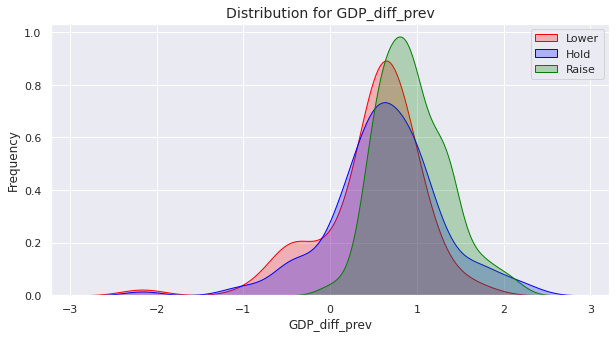

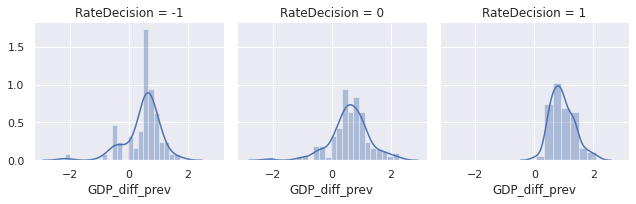

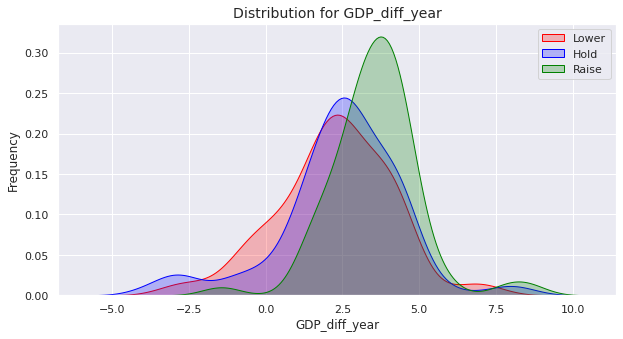

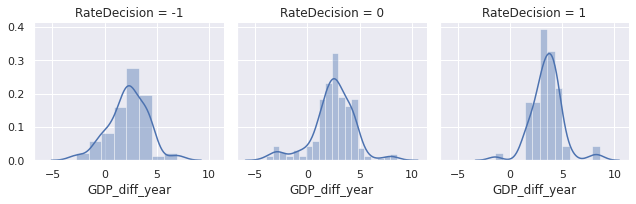

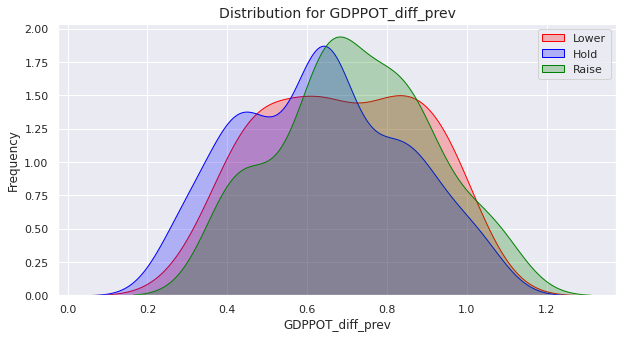

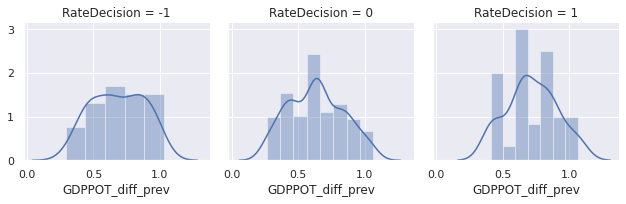

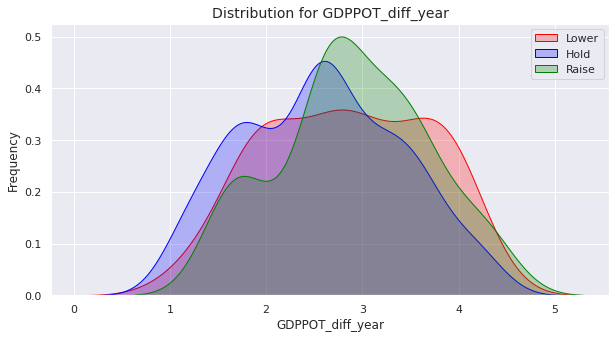

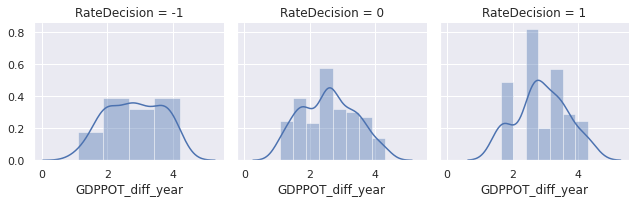

In [67]:
plot_distribution(nontext_data, ["GDP_diff_prev", "GDP_diff_year", "GDPPOT_diff_prev", "GDPPOT_diff_year"])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

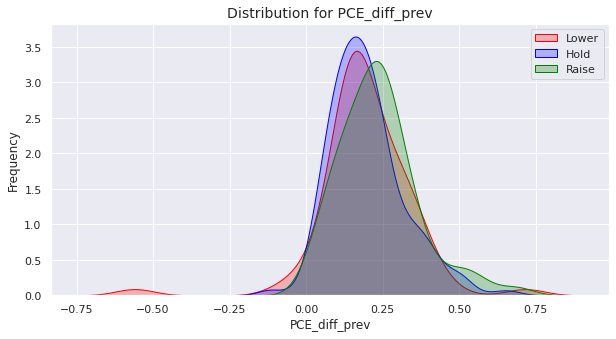

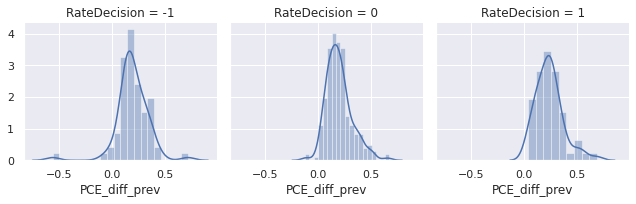

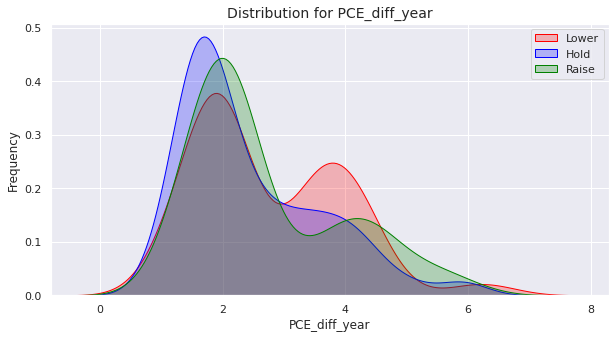

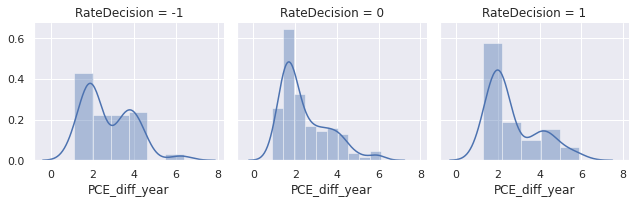

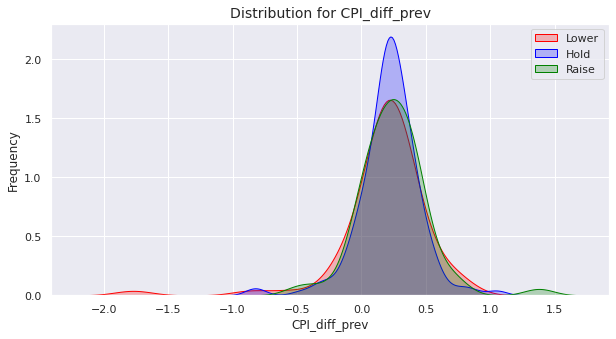

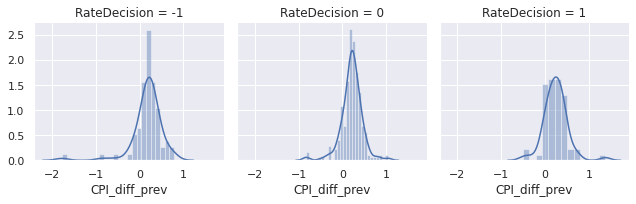

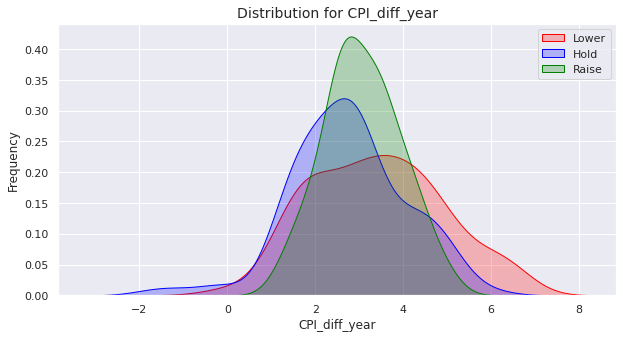

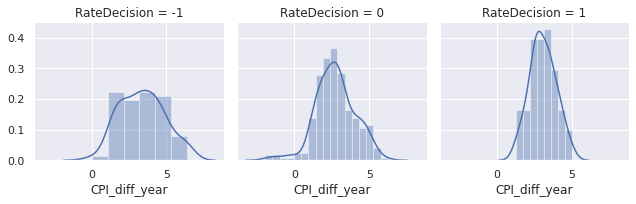

In [68]:
plot_distribution(nontext_data, ["PCE_diff_prev", "PCE_diff_year", "CPI_diff_prev", "CPI_diff_year"])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

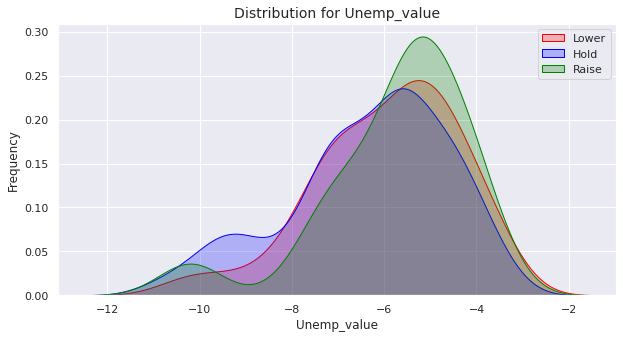

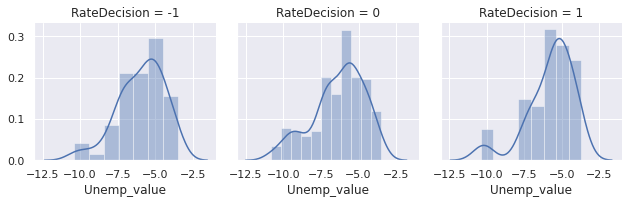

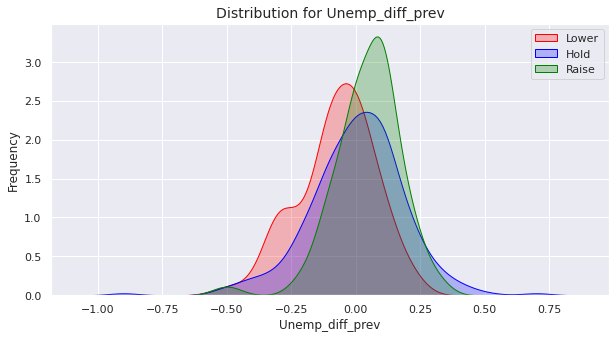

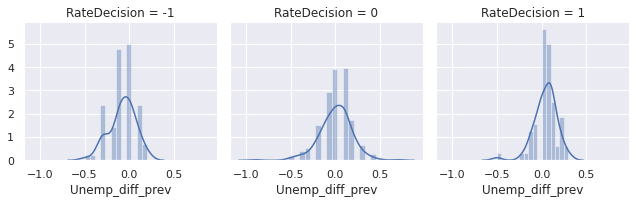

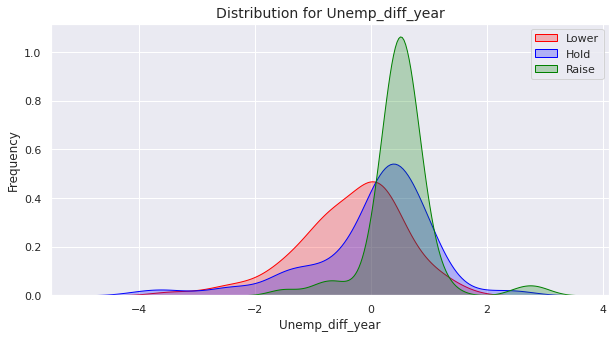

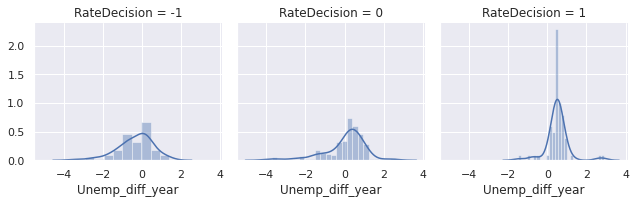

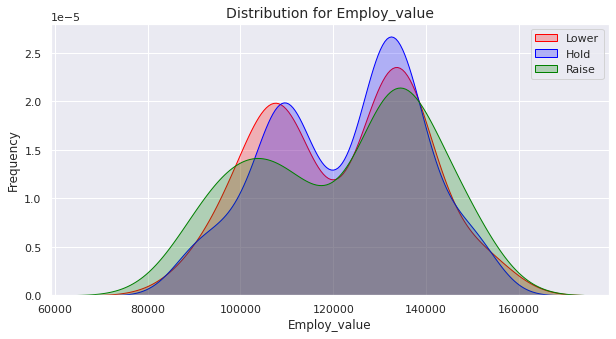

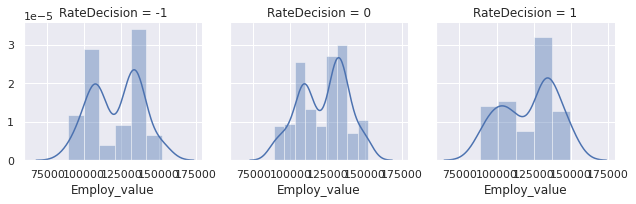

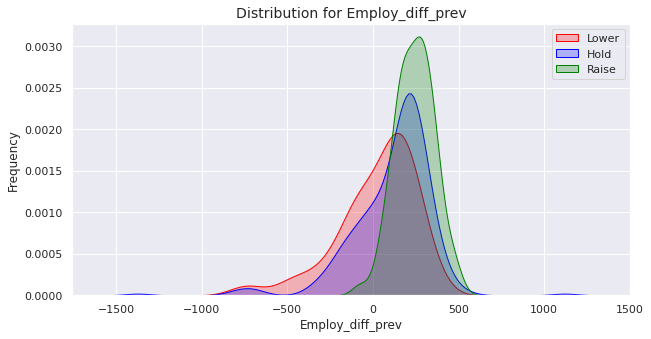

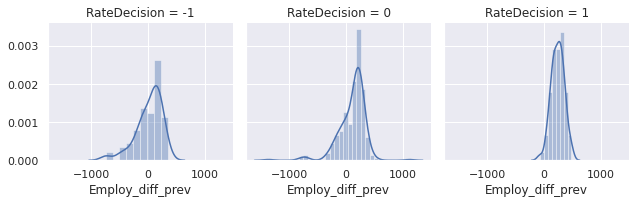

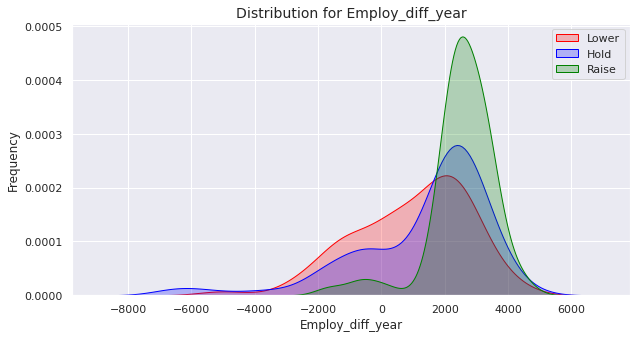

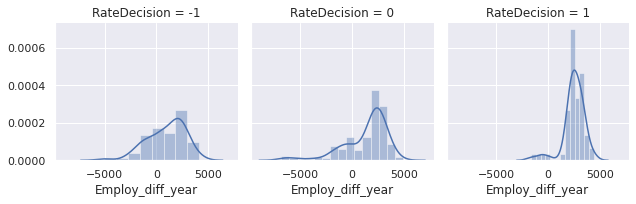

In [69]:
plot_distribution(nontext_data, ["Unemp_value", "Unemp_diff_prev", "Unemp_diff_year", "Employ_value", "Employ_diff_prev", "Employ_diff_year"])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

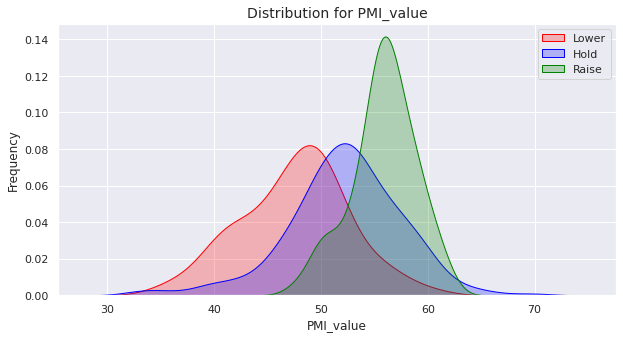

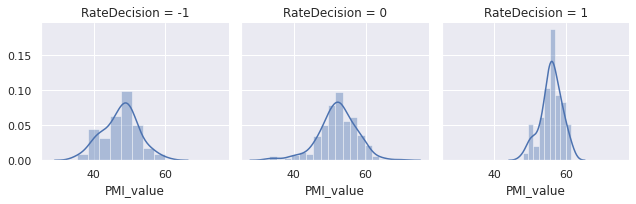

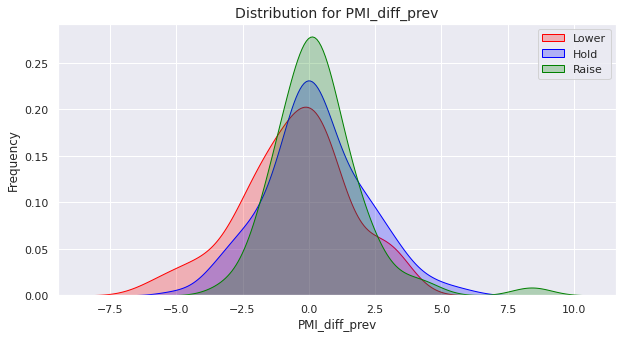

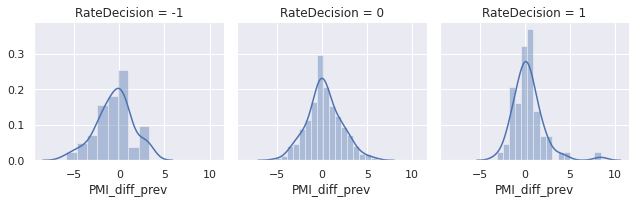

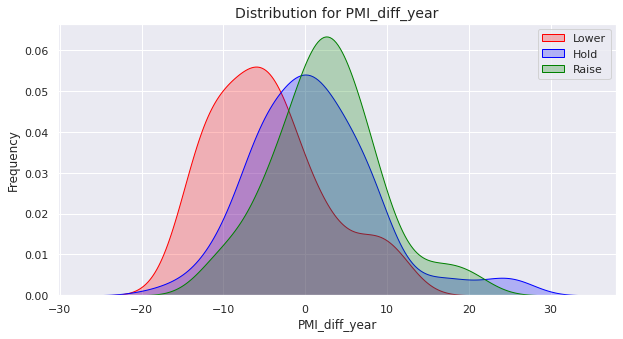

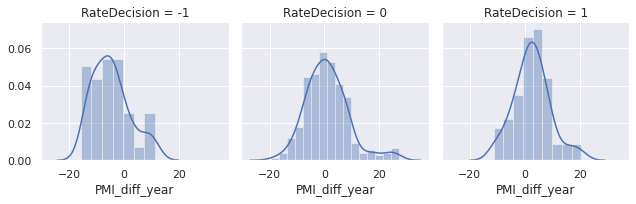

In [70]:
plot_distribution(nontext_data, ["PMI_value", "PMI_diff_prev", "PMI_diff_year"])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

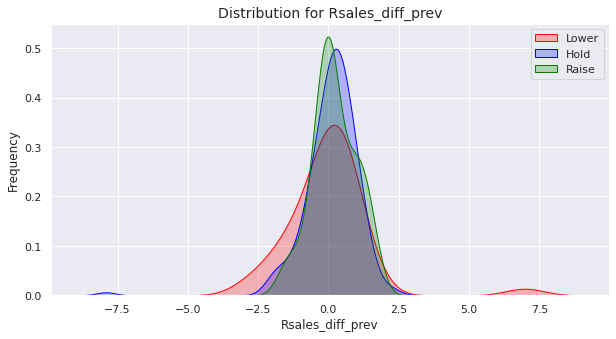

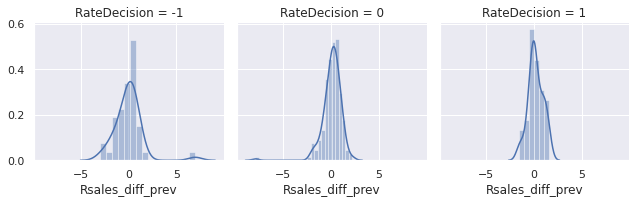

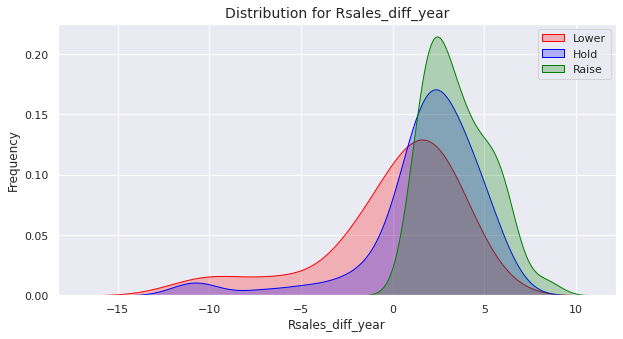

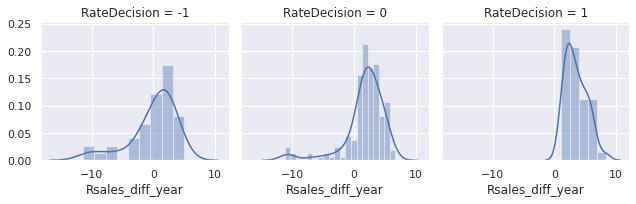

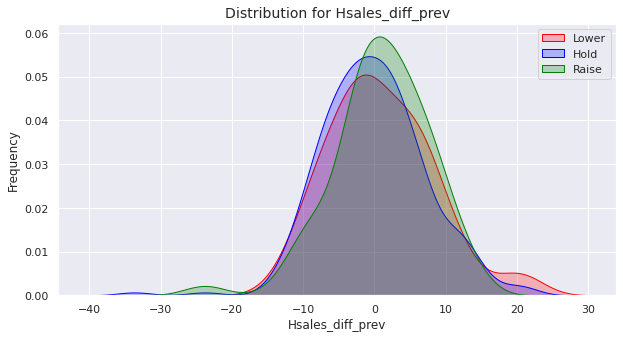

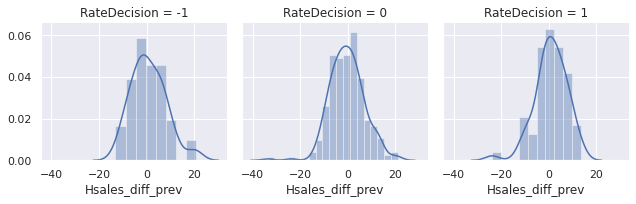

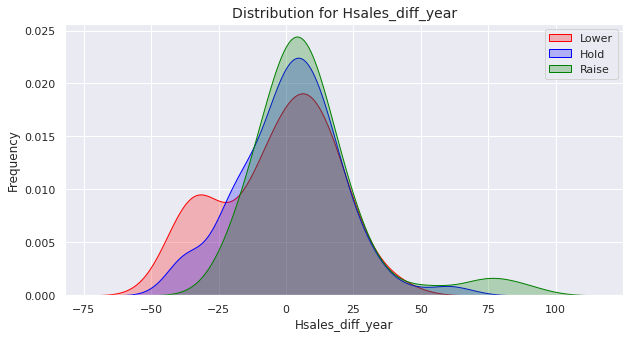

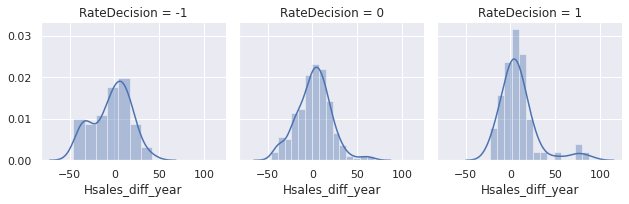

In [71]:
plot_distribution(nontext_data, ["Rsales_diff_prev", "Rsales_diff_year", "Hsales_diff_prev", "Hsales_diff_year"])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

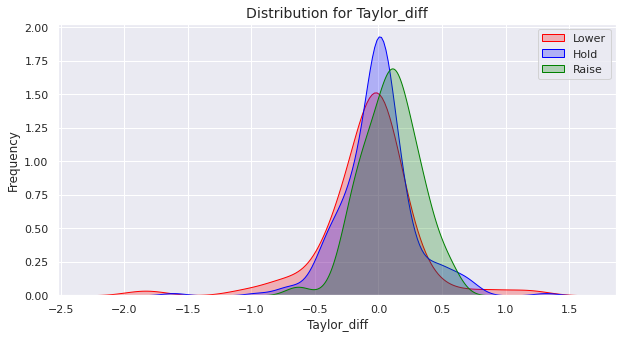

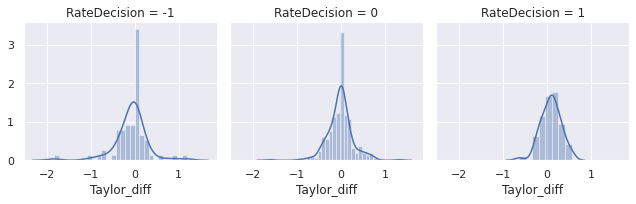

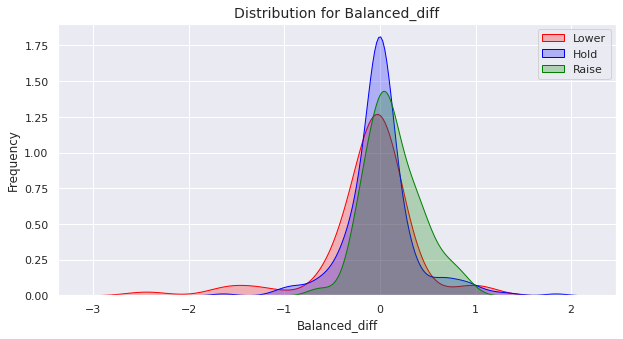

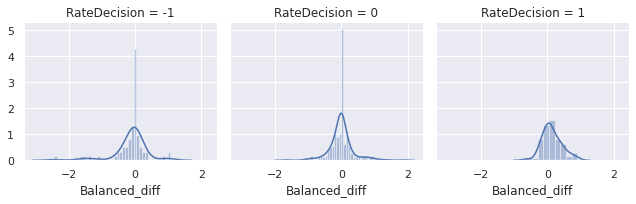

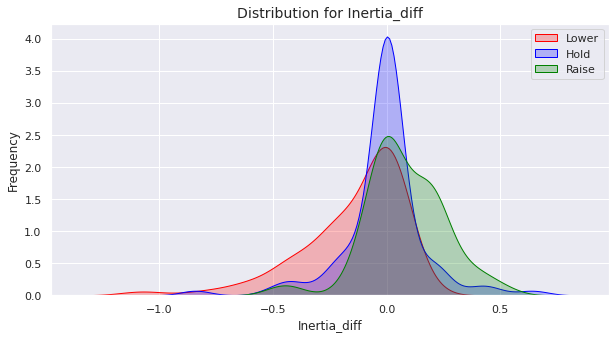

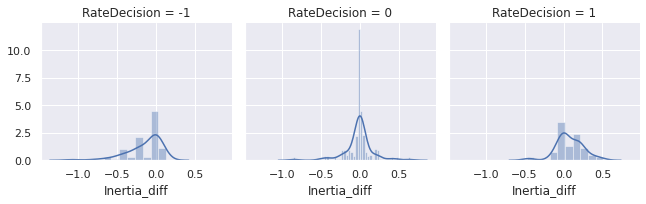

In [72]:
plot_distribution(nontext_data, ["Taylor_diff", "Balanced_diff", "Inertia_diff"])

### Create Training Data Set

In [73]:
nontext_train_small = pd.concat([nontext_data[['RateDecision', 'prev_decision', 'GDP_diff_prev', 'PMI_value']],
                                 nontext_ma2[['Employ_diff_prev', 'Rsales_diff_year']], 
                                 nontext_ma3[['Unemp_diff_prev', 'Inertia_diff']], 
                                 nontext_ma12[['Hsales_diff_year', 'Balanced_diff']]], axis=1)
nontext_train_small.rename(columns={'RateDecision': 'target'}, inplace=True)

In [74]:
nontext_train_small.isnull().sum()

target                0
prev_decision         1
GDP_diff_prev         0
PMI_value             0
Employ_diff_prev      0
Rsales_diff_year    131
Unemp_diff_prev       0
Inertia_diff          4
Hsales_diff_year      0
Balanced_diff        15
dtype: int64

In [75]:
latest_columns = ['RateDecision', 
                  'prev_decision',
                  'GDP_diff_prev', 
                  'GDP_diff_year', 
                  'GDPPOT_diff_prev', 
                  'GDPPOT_diff_year', 
                  'PCE_diff_prev', 
                  'PCE_diff_year', 
                  'CPI_diff_prev', 
                  'CPI_diff_year', 
                  'Unemp_value', 
                  'Unemp_diff_prev', 
                  'Unemp_diff_year', 
                  'Employ_value', 
                  'Employ_diff_prev', 
                  'Employ_diff_year', 
                  'PMI_value', 
                  'PMI_diff_prev', 
                  'PMI_diff_year', 
                  'Rsales_diff_prev', 
                  'Rsales_diff_year', 
                  'Hsales_diff_prev', 
                  'Hsales_diff_year', 
                  'Taylor-Rate', 
                  'Balanced-Rate', 
                  'Inertia-Rate', 
                  'Taylor_diff', 
                  'Balanced_diff', 
                  'Inertia_diff']

ma3_columns = [
               'GDP_diff_prev', 
               'GDP_diff_year', 
               'GDPPOT_diff_prev', 
               'GDPPOT_diff_year', 
               'PCE_diff_prev', 
               'PCE_diff_year', 
               'CPI_diff_prev', 
               'CPI_diff_year', 
               'Unemp_value', 
               'Unemp_diff_prev', 
               'Unemp_diff_year', 
               'Employ_value', 
               'Employ_diff_prev', 
               'Employ_diff_year', 
               'PMI_value', 
               'PMI_diff_prev', 
               'PMI_diff_year', 
               'Rsales_diff_prev', 
               'Rsales_diff_year', 
               'Hsales_diff_prev', 
               'Hsales_diff_year', 
               'Taylor-Rate', 
               'Balanced-Rate', 
               'Inertia-Rate', 
               'Taylor_diff', 
               'Balanced_diff', 
               'Inertia_diff'
               ]

nontext_train_large = pd.concat([nontext_data[latest_columns], nontext_ma3[ma3_columns].add_suffix('_ma3')], axis=1)
nontext_train_large.rename(columns={'RateDecision': 'target'}, inplace=True)
print(nontext_data[latest_columns].shape)
print(nontext_ma3[ma3_columns].shape)
print(nontext_train_large.shape)

(390, 29)
(390, 27)
(390, 56)


In [76]:
nontext_train_large.isnull().sum()

target                    0
prev_decision             1
GDP_diff_prev             0
GDP_diff_year             0
GDPPOT_diff_prev          0
GDPPOT_diff_year          0
PCE_diff_prev             0
PCE_diff_year             0
CPI_diff_prev             0
CPI_diff_year             0
Unemp_value               0
Unemp_diff_prev           0
Unemp_diff_year           0
Employ_value              0
Employ_diff_prev          0
Employ_diff_year          0
PMI_value                 0
PMI_diff_prev             0
PMI_diff_year             0
Rsales_diff_prev        117
Rsales_diff_year        129
Hsales_diff_prev          0
Hsales_diff_year          0
Taylor-Rate               0
Balanced-Rate             0
Inertia-Rate              0
Taylor_diff               1
Balanced_diff             1
Inertia_diff              1
GDP_diff_prev_ma3         0
GDP_diff_year_ma3         0
GDPPOT_diff_prev_ma3      0
GDPPOT_diff_year_ma3      0
PCE_diff_prev_ma3         0
PCE_diff_year_ma3         0
CPI_diff_prev_ma3   

### Missing Values

In [77]:
nontext_train_small['prev_decision'].fillna(0, inplace=True)
nontext_train_large['prev_decision'].fillna(0, inplace=True)

(0.0, 400.0)

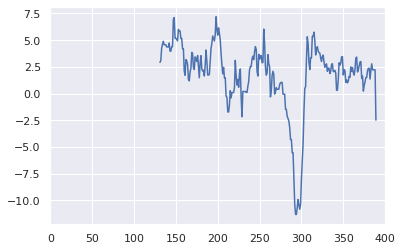

In [78]:
ax = sns.lineplot(data=nontext_train_small['Rsales_diff_year'].values)
ax.set_xlim(0, 400)

(0.0, 400.0)

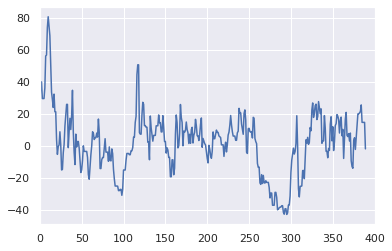

In [79]:
ax = sns.lineplot(data=nontext_ma2['Hsales_diff_year'].values)
ax.set_xlim(0, 400)

In [80]:
nontext_train_small['Rsales_diff_year'].fillna(nontext_train_small['Rsales_diff_year'].mean(), inplace=True)
nontext_train_large['Rsales_diff_prev'].fillna(nontext_train_large['Rsales_diff_prev'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year'].fillna(nontext_train_large['Rsales_diff_year'].mean(), inplace=True)

nontext_train_small['Inertia_diff'].fillna(nontext_train_small['Inertia_diff'].mean(), inplace=True)
nontext_train_small['Balanced_diff'].fillna(nontext_train_small['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Inertia_diff'].fillna(nontext_train_large['Inertia_diff'].mean(), inplace=True)
nontext_train_large['Balanced_diff'].fillna(nontext_train_large['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Taylor_diff'].fillna(nontext_train_large['Taylor_diff'].mean(), inplace=True)

nontext_train_large['Rsales_diff_prev_ma3'].fillna(nontext_train_large['Rsales_diff_prev_ma3'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year_ma3'].fillna(nontext_train_large['Rsales_diff_year_ma3'].mean(), inplace=True)

nontext_train_large['Inertia_diff_ma3'].fillna(nontext_train_large['Inertia_diff_ma3'].mean(), inplace=True)
nontext_train_large['Balanced_diff_ma3'].fillna(nontext_train_large['Balanced_diff_ma3'].mean(), inplace=True)
nontext_train_large['Taylor_diff_ma3'].fillna(nontext_train_large['Taylor_diff_ma3'].mean(), inplace=True)
nontext_train_large['Inertia-Rate_ma3'].fillna(nontext_train_large['Inertia-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Balanced-Rate_ma3'].fillna(nontext_train_large['Balanced-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Taylor-Rate_ma3'].fillna(nontext_train_large['Taylor-Rate_ma3'].mean(), inplace=True)


In [81]:
nontext_train_small.isnull().sum()


target              0
prev_decision       0
GDP_diff_prev       0
PMI_value           0
Employ_diff_prev    0
Rsales_diff_year    0
Unemp_diff_prev     0
Inertia_diff        0
Hsales_diff_year    0
Balanced_diff       0
dtype: int64

In [82]:
nontext_train_large.isnull().sum()


target                  0
prev_decision           0
GDP_diff_prev           0
GDP_diff_year           0
GDPPOT_diff_prev        0
GDPPOT_diff_year        0
PCE_diff_prev           0
PCE_diff_year           0
CPI_diff_prev           0
CPI_diff_year           0
Unemp_value             0
Unemp_diff_prev         0
Unemp_diff_year         0
Employ_value            0
Employ_diff_prev        0
Employ_diff_year        0
PMI_value               0
PMI_diff_prev           0
PMI_diff_year           0
Rsales_diff_prev        0
Rsales_diff_year        0
Hsales_diff_prev        0
Hsales_diff_year        0
Taylor-Rate             0
Balanced-Rate           0
Inertia-Rate            0
Taylor_diff             0
Balanced_diff           0
Inertia_diff            0
GDP_diff_prev_ma3       0
GDP_diff_year_ma3       0
GDPPOT_diff_prev_ma3    0
GDPPOT_diff_year_ma3    0
PCE_diff_prev_ma3       0
PCE_diff_year_ma3       0
CPI_diff_prev_ma3       0
CPI_diff_year_ma3       0
Unemp_value_ma3         0
Unemp_diff_p

### One-hot encoding

In [83]:
# nontext_train['Lower'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == -1 else 0)
# nontext_train['Hold'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == 0 else 0)
# nontext_train['Raise'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == 1 else 0)
# nontext_train

## Save Data

In [84]:
if IN_COLAB:
  def save_data(df, file_name, dir_name=preprocessed_dir, index_csv=True):
    if not os.path.exists(dir_name):
      os.mkdir(dir_name)
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print('Successfully saved {}.pickle. in {}'.format(file_name, dir_name + file_name + '.pickle'))
    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=index_csv)
    print('Successfully saved {}.csv. in {}'.format(file_name, dir_name + file_name + '.csv'))

else:
  def save_data(df, file_name, dir_name=preprocessed_dir, index_csv=True):
    # Save results to a .picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print('Successfully saved {}.pickle. in {}'.format(file_name, dir_name + file_name + '.pickle'))
    # Save results to a .csv file
    df.to_csv(dir_name + file_name + '.csv', index=index_csv)
    print('Successfully saved {}.csv. in {}'.format(file_name, dir_name + file_name + '.csv'))

In [85]:
# Save non-text data
save_data(nontext_train_small, 'nontext_train_small')
save_data(nontext_train_large, 'nontext_train_large')

Successfully saved nontext_train_small.pickle. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/nontext_train_small.pickle
Successfully saved nontext_train_small.csv. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/nontext_train_small.csv
Successfully saved nontext_train_large.pickle. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/nontext_train_large.pickle
Successfully saved nontext_train_large.csv. in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/nontext_train_large.csv
